<h1>Various Analyses</h1>

Trying different analyses on Decision Trees, Random Forests, and K-Fold Cross Validation through changing of parameters

In [299]:
from sklearn.datasets import load_iris # Iris dataset
from sklearn.model_selection import KFold # K-fold Cross Validation
from sklearn import tree # Decision Tree
from sklearn import ensemble # Random forest
from sklearn import metrics # Accuracy scores

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

<h2>Helper Functions</h2>

Function for obtaining data splits over k-folds

In [300]:
def getSets(k, data, targets):
    kFold = KFold(k, True, 1)

    # Data sets
    trainSets = []
    testSets = []
    # Target sets
    trainTargs = []
    testTargs = []
    
    for train, test in kFold.split(data):
        # Training values
        trainSets.append( [data[i] for i in train] )
        trainTargs.append( [targets[i] for i in train] )

        # Testing values
        testSets.append( [data[i] for i in test] )
        testTargs.append( [targets[i] for i in test] )
        
    return trainSets, testSets, trainTargs, testTargs

Function for printing out accuracy results

In [301]:
def printScores(scores):
    # Results
    for score in scores:
        print("Accuracy: {0:0.4f}".format(score))        

Function for plotting results / scores

In [302]:
def plotSingleScore(scores, xL, yL, t):
    n = len(scores)
    x = np.linspace(0, n, num = n)
    
    fig = plt.figure()
    p1 = fig.add_subplot()
    # It's the holidays
    p1.plot(x, scores,
             color = "forestgreen",
             marker = "*",
             markersize = "10",
             markeredgecolor = "indianred",
             markerfacecolor = "indianred",)
    
    p1.set_xlabel(xL)
    p1.set_ylabel(yL)
    p1.set_title(t)
    plt.show()

In [303]:
def plotModelPerformance(df, xL):
    n = df.shape[0]
    x = np.linspace(0, n, num = n)
    
    fig, p = plt.subplots(2, 2, figsize=(12, 10))
    plots = {
        "accuracy": {
            "index": [0, 0],
            "yLabel": "Mean Accuracy",
            "color": "tomato"
        },
        "bias": {
            "index": [0, 1],
            "yLabel": "Mean Bias",
            "color": "orange"
        },
        "variance": {
            "index": [1, 0],
            "yLabel": "Mean Varianve",
            "color": "limegreen"
        },
        "mse": {
            "index": [1, 1],
            "yLabel": "Mean Square Errror",
            "color": "cornflowerblue"
        },
    }
    for column in df:
        currData = plots[column]
        index = currData["index"]
        p[index[0], index[1]].plot(x, column, data=df,
               color = currData["color"])
        p[index[0], index[1]].set_xlabel(xL)
        p[index[0], index[1]].set_ylabel(currData["yLabel"])
    
    print()
    plt.show()

Function for finding Variance

In [304]:
def getVariance(predictions):
    return np.mean((predictions - np.mean(predictions))**2)

Function for finding Bias

In [305]:
def getBias(predictions, target):
    truth = np.mean(target)
    return np.mean(predictions) - truth

Function for finding Mean Square Error

In [306]:
def getMSE(predictions, target):
    truth = np.mean(target)
    return np.mean((predictions-truth)**2)

Loading Data sets

In [307]:
# Iris Dataset
iris = load_iris()

In [333]:
# Wine Quality Dataset
df = pd.read_csv('WineQuality/winequality-white.csv', delimiter=';')

wines = df.drop(columns='quality')
wines = wines.to_numpy()

targets = df['quality']
targets = targets.to_numpy()

<h1>Decision Trees</h1>

Analysis on how the maximum depth (`max_depth`) of a tree affects model accuracy and execution time

Function to run a Decision Tree with max_depth n over k-folds

In [334]:
def runDecisionTree(k, data, targets, n):
    accuracy = []
    squareErrors = []
    variances = []
    biases= []
    trainS, testS, trainT, testT = getSets(k, data, targets)
    
    for i in range(0, k):
        classTree = tree.DecisionTreeClassifier(max_depth = n)
        # Training
        classTree = classTree.fit(trainS[i], trainT[i])
        # Testing
        test = classTree.predict(testS[i])
        
        # Accuracy
        accuracy.append(metrics.accuracy_score(testT[i], test))
        # Variances
        variances.append(getVariance(test))
        # Biases
        biases.append(getBias(test, testT[i]))
        # Mean Square Error
        squareErrors.append(getMSE(test, testT[i]))
        
    # Mean results
    data = {
        "accuracy": np.mean(accuracy),
        "bias": np.mean(biases),
        "variance": np.mean(variances),
        "mse": np.mean(squareErrors)
    }
    return data

Function to run decision trees with max_depths within the range (start, end), over k-folds

In [335]:
def runTreeDepths(k, start, end, data, targets):
    allData = []
    for i in range(start, end):
        allData.append(runDecisionTree(k, data, targets, i))
    
    return pd.DataFrame(allData)        

<h3>Iris Flowers</h3>

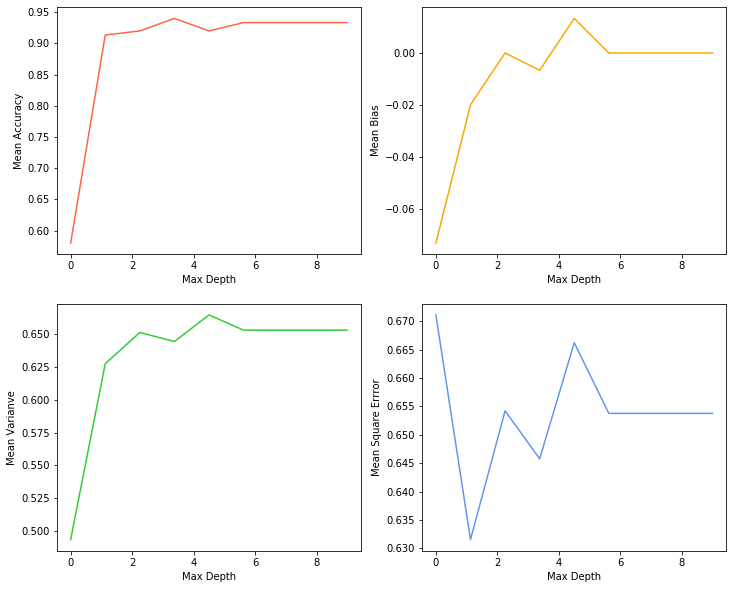

In [337]:
# Decision Trees with max depths 1-10 at 5-folds
result = runTreeDepths(5, 1, 10, iris.data, iris.target)

# Plot labels
xAxis = "Max Depth"
plotModelPerformance(result, xAxis)

<h3>Wine Quality</h3>

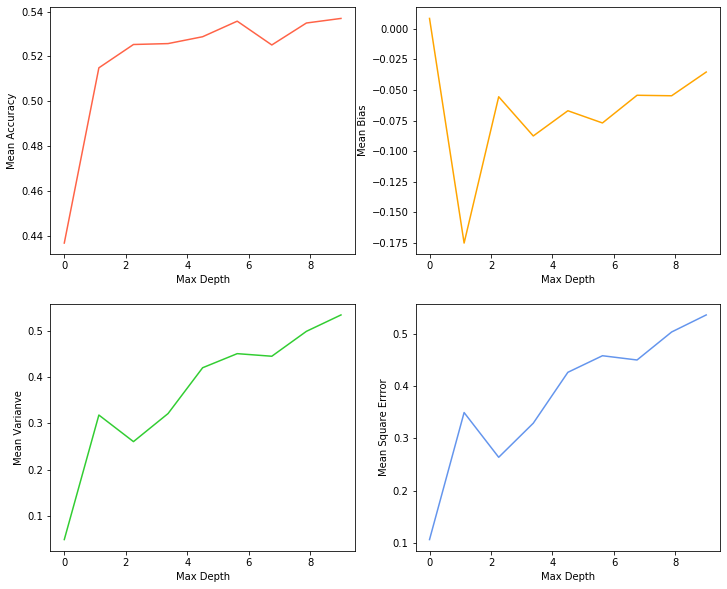

In [341]:
# Decision Trees with max depths 1-10 at 5-folds
result = runTreeDepths(5, 1, 10, wines, targets)

# Plot labels
xAxis = "Max Depth"
plotModelPerformance(result, xAxis)

<h1>Random Forest</h1>

Analysis on how the number of trees (`n_estimators`) in a forest effects model accuracy and execution time

Function to run a Random Forest over k-folds with n trees

In [342]:
def runRandomForest(k, n, data, targets, d):
    accuracy = []
    squareErrors = []
    variances = []
    biases= []
    trainS, testS, trainT, testT = getSets(k, data, targets)
    
    for i in range(0, k):
        forest = ensemble.RandomForestClassifier(n_estimators = n, max_depth = d)
        # Training
        forest = forest.fit(trainS[i], trainT[i])
        # Testing
        test = forest.predict(testS[i])
        
        # Accuracy
        accuracy.append(metrics.accuracy_score(testT[i], test))
        # Variances
        variances.append(getVariance(test))
        # Biases
        biases.append(getBias(test, testT[i]))
        # Mean Square Error
        squareErrors.append(getMSE(test, testT[i]))
        
    # Mean results
    data = {
        "accuracy": np.mean(accuracy),
        "bias": np.mean(biases),
        "variance": np.mean(variances),
        "mse": np.mean(squareErrors)
    }
    
    # Printing results
    return data

Function to run Random Forests of range(start, end) trees with max_depth d over k-folds

In [343]:
def runForestNums(k, start, end, data, targets, d):
    allData = []
    for i in range(start, end):
        allData.append(runRandomForest(k, i, data, targets, d))
        
    return pd.DataFrame(allData)

<h3>Iris Flowers</h3>

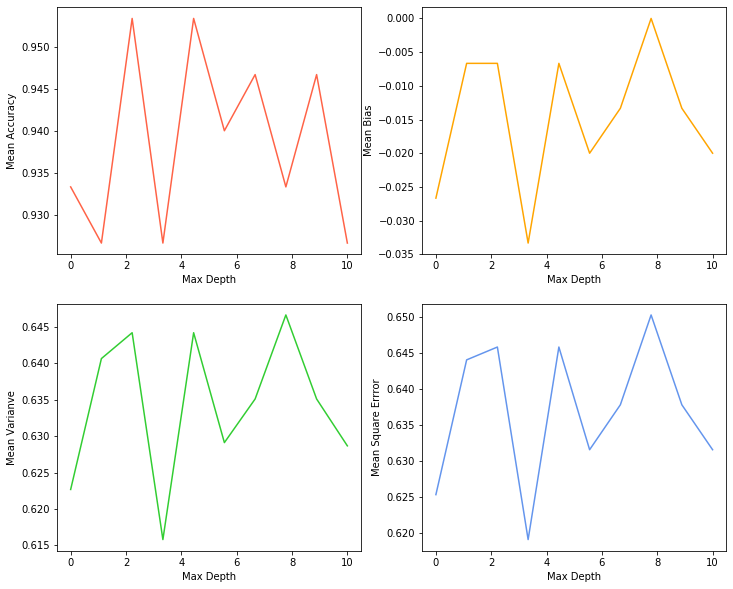

In [359]:
# Random Forest with trees of max depth 5 and 10-20 trees
result = runForestNums(5, 10, 20, iris.data, iris.target, 5)

# Plot labels
xAxis = "Max Depth"
plotModelPerformance(result, xAxis)

<h3>Wine Quality</h3>

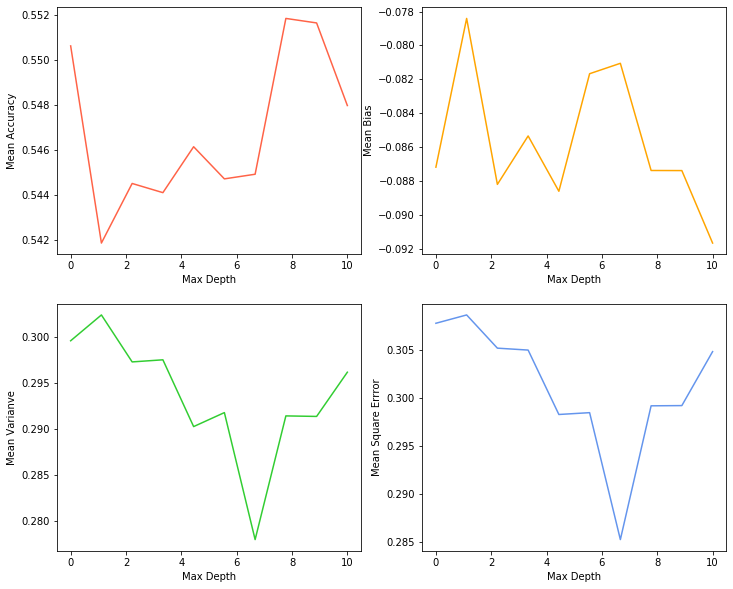

In [361]:
# Random Forest with trees of max depth 5 and 10-20 trees
result = runForestNums(5, 10, 20, wines, targets, 5)

# Plot labels
xAxis = "Max Depth"
plotModelPerformance(result, xAxis)

<h1>K-Fold Cross Validation</h1>

Analysis on how number of folds (`k`) affects the validation of a model

<h3>Iris Flowers</h3>

In [141]:
print('h')

h


<h3>Wine Quality</h3>

In [142]:
print('hh')

hh
